# 기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 분류하기
-   18개 언어로 된 수천 개의 성(姓)을 훈련시키고, 철자에 따라 이름이 어떤 언어인지 예측

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# 이름을 Tensor로 변경
-   하나의 문자를 표현하기 위해 크기가 <1 * n_letters>인 One-Hot 벡터를 사용

In [3]:
'''
.. NOTE::
역자 주:  One-Hot 벡터는 언어를 다룰 때 자주 이용되며,
단어, 글자 등을 벡터로 표현할 때 단어, 글자 사이의 상관 관계를 미리 알 수 없을 경우,
One-Hot으로 표현하여 서로 직교한다고 가정하고 학습을 시작합니다.
이와 동일하게, 상관 관계를 알 수 없는 다른 데이터의 경우에도 One-Hot 벡터를 활용할 수 있습니다.
'''

import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한 개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


c:\Users\kimju\OneDrive\바탕 화면\Study\파이썬\machine learning\pytorch_practice\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 네트워크 생성
-   Torch에서 RNN 생성은 여러 시간열 단계를 걸쳐서 계층의 매개변수를 복제하는 작업을 포함
-   계층은 은닉 상태와 기울기(Gradient)를 가지며, 그래프 자체에서 처리된다.  
![](https://velog.velcdn.com/images/afsd721/post/30c59fb1-5f59-4e95-9fd9-1090d1461a03/image.png)

In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [5]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [6]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.0025, -3.0069, -2.8606, -2.8703, -2.8725, -2.9542, -2.9536, -2.8026,
         -2.7733, -2.7937, -2.7785, -2.9466, -2.9737, -2.8257, -2.9217, -2.8379,
         -2.9809, -2.9246]], grad_fn=<LogSoftmaxBackward0>)


# 학습
## 학습 준비

In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)  # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()   # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 8)


In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Russian / line = Vakichev
category = Czech / line = Rozinek
category = Polish / line = Grzeskiewicz
category = Dutch / line = Andringa
category = Japanese / line = Shirasu
category = Czech / line = Skokan
category = German / line = Wendell
category = French / line = Duchamps
category = Japanese / line = Tsukatani
category = Czech / line = Swatchak


# 신경망 학습
-   RNN 마지막 계층이 nn.LogSoftmax 이므로 손실 함수로 nn.NLLLoss가 적합
-   각각의 학습 루프는 다음과 같다.
    -   입력과 목표 Tensor 생성
    -   0으로 초기화된 은닉상태 생성
    -   각 문자 읽기
    -   다음 문자를 위한 은닉상태 유지
    -   목표와 최종 출력 비교
    -   역전파
    -   출력과 손실 반환
    

In [9]:
criterion = nn.NLLLoss()

In [10]:
learning_rate = 0.005  # 학습률을 너무 높게 설정하면 발산할 수 있고, 너무 낮으면 학습이 되지 않을 수 있습니다.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [11]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 2s) 1.4401 Kedzierski / Polish ✓
10000 10% (0m 3s) 2.0092 Gibson / Scottish ✓
15000 15% (0m 6s) 1.4625 Hong / Chinese ✗ (Korean)
20000 20% (0m 8s) 1.4328 Uoya / Japanese ✓
25000 25% (0m 10s) 2.7245 Peigne / Vietnamese ✗ (English)
30000 30% (0m 12s) 1.0239 Pharlain / Irish ✓
35000 35% (0m 14s) 1.8139 Jukhman / Polish ✗ (Russian)
40000 40% (0m 16s) 3.4908 Hahn / Korean ✗ (German)
45000 45% (0m 18s) 1.5241 Osladil / Czech ✓
50000 50% (0m 20s) 0.9608 Demetrious / Greek ✓
55000 55% (0m 22s) 0.9554 Araullo / Portuguese ✓
60000 60% (0m 24s) 5.2544 Benetton / Scottish ✗ (Italian)
65000 65% (0m 26s) 0.3862 Dam / Vietnamese ✓
70000 70% (0m 28s) 1.8532 Zhebit / French ✗ (Russian)
75000 75% (0m 30s) 0.2424 Mustafa / Arabic ✓
80000 80% (0m 32s) 0.0199 Ilyumjinov / Russian ✓
85000 85% (0m 34s) 0.1380 Marshall / Scottish ✓
90000 90% (0m 36s) 2.2067 Puerta / Czech ✗ (Spanish)
95000 95% (0m 38s) 1.9713 Suero / Dutch ✗ (Spanish)
100000 100% (0m 40s) 2.9953 Broz / Korean ✗ (Polish)


# 결과 도식화

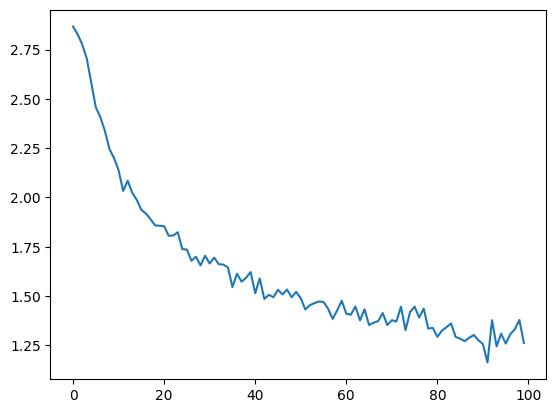

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# 결과 평가
-   네트워크가 다른 카테고리에서 얼마나 잘 작동하는지 보기 위해 모든 실제 언어가 네트워크에서 어떤 언어로 추측되는지 나타내는 혼란 행렬(confusion matrix)를 생성
-   혼란 행렬을 계산하기 위해 evaluate() 로 많은 수의 샘플을 네트워크에 실행

C:\Users\kimju\AppData\Local\Temp\ipykernel_11636\2811754854.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\kimju\AppData\Local\Temp\ipykernel_11636\2811754854.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


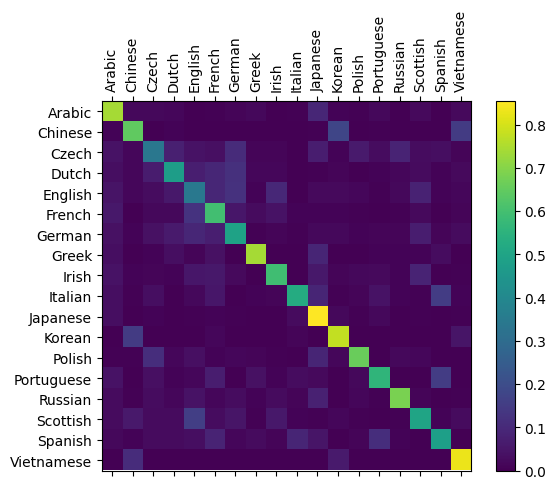

In [13]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 예시 중 어떤 것이 정확히 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# 사용자 입력으로 실행


In [16]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Lee')
predict('Kim')


> Dovesky
(-0.76) Czech
(-1.03) Russian
(-2.17) English

> Jackson
(-0.60) Scottish
(-1.34) English
(-2.54) Russian

> Satoshi
(-1.05) Italian
(-1.56) Japanese
(-1.88) Arabic

> Lee
(-0.96) Chinese
(-0.97) Vietnamese
(-2.79) French

> Kim
(-1.26) Chinese
(-1.28) Korean
(-2.35) Vietnamese
